In [1]:
import numpy as np
import random
from option import Option

""" Simple agent using Monte-Carlo model learning, selecting actions
    randomly """
class MonteCarloModelLearningAgent():
    def __init__(self, gamma=0.9):    
        # List of all options
        self.options = \
         [Option("left"), Option("up"), Option("right"), Option("down"),
          Option("topleft->topright"), Option("topleft->botleft"),
          Option("topright->topleft"), Option("topright->botright"),
          Option("botleft->topleft"), Option("botleft->botright"),
          Option("botright->botleft"), Option("botright->topright")]
        
        self.gamma = gamma # Discount factor, 0.9 by default as in paper
        self.current_option = None
        self.starting_state = None # Starting state of current option
        self.k = 0   # Number of time steps elapsed in current option
        self.cumulative_reward = 0  # Total reward for current option
        
        # R[s, o] = expected cumulative discounted reward when starting
        #   option o in state s
        # P[s, o, s'] = multi-time model of ending up in state s' when 
        #   starting option o in state s
        # N[s, o] = number of times option o is taken in state s
        n_states = 13 * 13
        n_options = len(self.options)
        self.R = np.zeros((n_states, n_options))
        self.P = np.zeros((n_states, n_options, n_states))
        self.N = np.zeros((n_states, n_options))
        
    def randomPolicy(self, state):
        # If we are not currently following an option
        if self.current_option is None:
            # Pick a new option and record starting state
            self._pickNewOption(state)
        
        # Select action according to policy of current option 
        action, _ = self.current_option.pickAction(state)
        return action
    
    # Remark : state argument is unused, we update only for the starting
    # state of the finishing option (which is recorded in the agent)
    def recordTransition(self, state, reward, next_state):
        # Add reward discounted by current discounting factor
        self.cumulative_reward += (self.gamma ** self.k) * reward
        self.k += 1 # Increment k after
        
        # If current option terminates at next state
        if self.current_option.beta[next_state] == 1:
            # Update N, R and P tables
            self._updateTables(reward, next_state)
            # Reset current option to None
            self._resetCurrentOption()
        
    def _sIdx(self, state):
        return state[0] * 13 + state[1]
    
    def _oIdx(self, option):
        return self.options.index(option)
        
    def _pickNewOption(self, state):
        # Generate list of valid options
        available_options = []
        for option in self.options:
            if option.I[state] == 1:
                available_options.append(option) 
        # Pick one randomly
        self.current_option = random.choice(available_options)  
        # Set starting state of option
        self.starting_state = state
    
    def _updateTables(self, reward, next_state):
        s1 = self._sIdx(self.starting_state)
        o = self._oIdx(self.current_option)
        s2 = self._sIdx(next_state)
        
        # Update N, R and P tables
        self.N[s1, o] += 1
        alpha = (1. / self.N[s1, o])
        self.R[s1, o] += alpha * (self.cumulative_reward - self.R[s1, o])
        self.P[s1, o, s2] += alpha * (self.gamma ** self.k) 
        self.P[s1, o] -= alpha * self.P[s1, o]
        
    def _resetCurrentOption(self):
        self.k = 0
        self.cumulative_reward = 0
        self.current_option = None
        self.starting_state = None

In [2]:
# Learn model
#for i in xrange(100000):
#    run_episode()
#np.save("save/R_MC_estimates_100k.npy", agent.R)
#np.save("save/P_MC_estimates_100k.npy", agent.P)

In [3]:
""" Agent using Intra-Option model learning, selecting actions
    randomly """
class IntraOptionModelLearningAgent():
    def __init__(self, gamma=0.9):    
        self.options = \
         [Option("left"), Option("up"), Option("right"), Option("down"),
          Option("topleft->topright"), Option("topleft->botleft"),
          Option("topright->topleft"), Option("topright->botright"),
          Option("botleft->topleft"), Option("botleft->botright"),
          Option("botright->botleft"), Option("botright->topright")]
            
        self.gamma = gamma
        self.current_option = None
        # Keep track of action number corresponding to last action taken
        self.last_action_taken = None
        
        n_states = 13 * 13
        n_options = len(self.options)
        self.R = np.zeros((n_states, n_options))
        self.P = np.zeros((n_states, n_options, n_states))
        self.N = np.zeros((n_states, n_options))
        
    def randomPolicy(self, state):
        if self.current_option is None:
            self._pickNewOption(state)
        action, action_number = self.current_option.pickAction(state)
        # Record action number corresponding to last action taken
        self.last_action_taken = action_number
        return action
    
    def recordTransition(self, state, reward, next_state):
        # Update tables on every transition
        self._updateTables(state, reward, next_state)
        if self.current_option.beta[next_state] == 1:
            self.current_option = None
        
    def _sIdx(self, state):
        return state[0] * 13 + state[1]
    
    def _oIdx(self, option):
        return self.options.index(option)
        
    def _pickNewOption(self, state):
        available_options = []
        for option in self.options:
            if option.I[state] == 1:
                available_options.append(option) 
        self.current_option = random.choice(available_options)  
    
    # Most of the work is done here
    def _updateTables(self, state, reward, next_state):
        s1 = self._sIdx(state)
        s2 = self._sIdx(next_state)
        
        # List of all options consistent with last action taken
        consistent_options = []
        for option in self.options:
            if option.pi[state] == self.last_action_taken:
                consistent_options.append(option)
        
        # Update table for every option consistent with last action taken
        for option in consistent_options:
            o = self._oIdx(option)
            
            # Update N table
            #self.N[s1, o] += 1
            #alpha = (1. / self.N[s1, o])
            alpha = 0.25

            # Update R table
            r_target = reward + self.gamma * \
                (1 - option.beta[next_state]) * self.R[s2, o]
            self.R[s1, o] += alpha * (r_target - self.R[s1, o])

            # Update P table
            p_target_all = self.gamma * (1 - option.beta[next_state]) * \
                self.P[s2, o]
            self.P[s1, o] += alpha * (p_target_all - self.P[s1, o])
            self.P[s1, o, s2] += alpha * self.gamma * \
                option.beta[next_state]

In [9]:
from four_rooms import FourRoomsEnvironment

env = FourRoomsEnvironment()

def run_episode(agent):
    state = env.reset()
    while True:
        action = agent.randomPolicy(state)
        next_state, reward, done = env.step(action)
        agent.recordTransition(state, reward, next_state)
        state = next_state
        if done:
            break

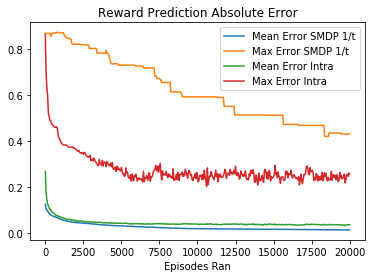

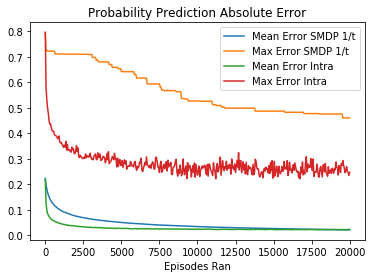

In [10]:
import matplotlib.pyplot as plt

# Consider MC values after 100K episodes as ground truth
R = np.load("save/R_MC_estimates_100k.npy")
P = np.load("save/P_MC_estimates_100k.npy")

""" Plot learning curves """
n_states = 104
n_episodes = 20001
step_size = 50 # Number of episodes between two recordings
n_repetitions = 10

# Keep track of statistics to plot learning curves
overall_mean_R_error_SMDP = [] 
overall_max_R_error_SMDP = []
overall_mean_R_error_IO = []
overall_max_R_error_IO = []
overall_mean_P_error_SMDP = [] 
overall_max_P_error_SMDP = []
overall_mean_P_error_IO = []
overall_max_P_error_IO = []


for i in xrange(n_repetitions):
    agentSMDP = MonteCarloModelLearningAgent()
    agentIO = IntraOptionModelLearningAgent()
    
    # Mean and max over all states and 8 hallway options
    mean_R_error_SMDP = []
    max_R_error_SMDP = []
    mean_R_error_IO = []
    max_R_error_IO = []
    # Mean and max over all states, 8 hallway options and next states
    mean_P_error_SMDP = []
    max_P_error_SMDP = []
    mean_P_error_IO = []
    max_P_error_IO = []
    
    for i in xrange(n_episodes):
        run_episode(agentSMDP)
        run_episode(agentIO)

        if i % step_size == 0:
            """ Estimate reward prediction error """
            R_error_SMDP = np.absolute(agentSMDP.R[:, 4:] - R[:, 4:])
            # Can only take 2 hallway options in each state
            mean_R_error_SMDP.append(np.sum(R_error_SMDP) / (n_states * 2))
            max_R_error_SMDP.append(np.max(R_error_SMDP))
            
            R_error_IO = np.absolute(agentIO.R[4:] - R[4:])
            mean_R_error_IO.append(np.sum(R_error_IO) / n_states)
            max_R_error_IO.append(np.max(R_error_IO))
            
            """ Estimate probability prediction error """
            P_error_SMDP = np.absolute(agentSMDP.P[:, 4:, :] - P[:, 4:, :])
            # Can only take 2 hallway options in each state
            # Each hallway option can only end up in one of 2 states
            mean_P_error_SMDP.append(np.sum(P_error_SMDP) / (n_states * 4))
            max_P_error_SMDP.append(np.max(P_error_SMDP))

            P_error_IO = np.absolute(agentIO.P[:, 4:, :] - P[:, 4:, :])
            mean_P_error_IO.append(np.sum(P_error_IO) / (n_states * 4))
            max_P_error_IO.append(np.max(P_error_IO))
            
    overall_mean_R_error_SMDP.append(mean_R_error_SMDP)
    overall_max_R_error_SMDP.append(max_R_error_SMDP)
    overall_mean_R_error_IO.append(mean_R_error_IO)
    overall_max_R_error_IO.append(max_R_error_IO)
    overall_mean_P_error_SMDP.append(mean_P_error_SMDP)
    overall_max_P_error_SMDP.append(max_P_error_SMDP)
    overall_mean_P_error_IO.append(mean_P_error_IO)
    overall_max_P_error_IO.append(max_P_error_IO)
    
# Average over all repetitions of experiment
overall_mean_R_error_SMDP = np.array(overall_mean_R_error_SMDP).mean(axis=0)
overall_max_R_error_SMDP = np.array(overall_max_R_error_SMDP).mean(axis=0)
overall_mean_R_error_IO = np.array(overall_mean_R_error_IO).mean(axis=0)
overall_max_R_error_IO = np.array(overall_max_R_error_IO).mean(axis=0)
overall_mean_P_error_SMDP = np.array(overall_mean_P_error_SMDP).mean(axis=0)
overall_max_P_error_SMDP = np.array(overall_max_P_error_SMDP).mean(axis=0)
overall_mean_P_error_IO = np.array(overall_mean_P_error_IO).mean(axis=0)
overall_max_P_error_IO = np.array(overall_max_P_error_IO).mean(axis=0)
    
plt.title("Reward Prediction Absolute Error")
plt.xlabel("Episodes Ran")
plt.plot(xrange(0, n_episodes, step_size), 
         overall_mean_R_error_SMDP, label="Mean Error SMDP 1/t")
plt.plot(xrange(0, n_episodes, step_size), 
         overall_max_R_error_SMDP, label="Max Error SMDP 1/t")
plt.plot(xrange(0, n_episodes, step_size), 
         overall_mean_R_error_IO, label="Mean Error Intra")
plt.plot(xrange(0, n_episodes, step_size), 
         overall_max_R_error_IO, label="Max Error Intra")
plt.legend()
plt.savefig("plots/reward_pred_error.png")
plt.show()

plt.title("Probability Prediction Absolute Error")
plt.xlabel("Episodes Ran")
plt.plot(xrange(0, n_episodes, step_size), 
         overall_mean_P_error_SMDP, label="Mean Error SMDP 1/t")
plt.plot(xrange(0, n_episodes, step_size), 
         overall_max_P_error_SMDP, label="Max Error SMDP 1/t")
plt.plot(xrange(0, n_episodes, step_size), 
         overall_mean_P_error_IO, label="Mean Error Intra")
plt.plot(xrange(0, n_episodes, step_size), 
         overall_max_P_error_IO, label="Max Error Intra")
plt.legend()
plt.savefig("plots/probability_pred_error.png")
plt.show()